In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import Dataset ,DataLoader

In [2]:
class AbsDataset(Dataset):
    
    def __init__(self, transform=None):
        xy = np.loadtxt('6Combinations.csv',delimiter=",", dtype=np.float32, skiprows=1)
        np.random.shuffle(xy)
        idx = np.random.randint(400, size=300)
        xy = xy[idx,:]
        self.x = xy[:,:6]
        self.y = xy[:,6:]
        self.n_samples = xy.shape[0]
        
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples

class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
dataset = AbsDataset(transform=ToTensor())
composed = torchvision.transforms.Compose([ToTensor()])
dataset_new = AbsDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [3]:
# hyperparameters
input_size = 6
hidden_size = 500
hidden_size2 = 500
num_classes = 776
num_epochs = 114
batch_size = 30
learning_rate = 0.001
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

300 75


In [4]:
train_size = int(0.7 * len(dataset_new)) # 70% of the samples for the training set
test_size = len(dataset_new) - train_size # 30% for the test set

# Train_loader (Shuffle) and Test_Loader (No Shuffle)
train_dataset, test_dataset = torch.utils.data.random_split(dataset_new, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders to be used to find the optimal configuration below 300Hz 
Low_Freq_Samples = torch.utils.data.DataLoader(dataset=dataset_new, batch_size=386, shuffle=False) # Real Samples
Low_Freq_Finder = torch.utils.data.DataLoader(dataset=dataset_new, batch_size=386, shuffle=False) # Samples that will be predicted by the ANN Model

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([30, 6]) torch.Size([30, 776])


In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, hidden_size2, num_classes)

Root Mean Squared Error
Training: 0.05858581750398293
Test 0.08388163


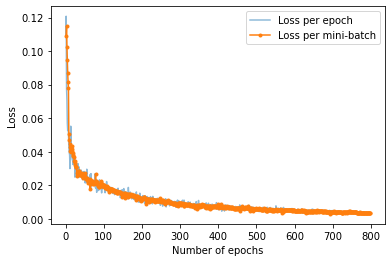

In [6]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Root Mean Squared Error")
print("Training:", np.sqrt(loss_per_batch[-1]))
print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Absolute Percentage Error
Training: 8.042376722608294
Test 13.865476


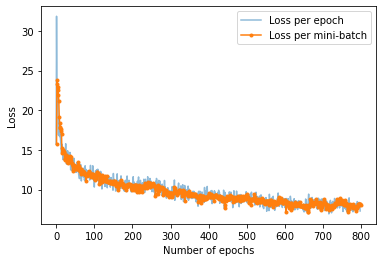

In [7]:
def MAPE(outputs, labels):
    outputs, labels = outputs, labels
    return torch.mean(torch.abs((labels - outputs) / labels)) * 100

# Loss and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = MAPE(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Mean Absolute Percentage Error")
print("Training:", (loss_per_batch[-1]))
print("Test", (MAPE(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Absolute Error
Training: 0.01754610612988472
Test 0.03885107


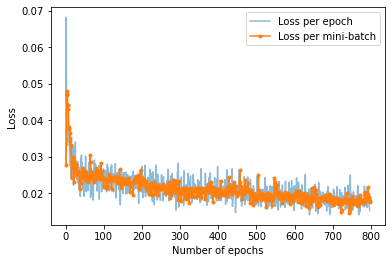

In [8]:
# Loss and Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Mean Absolute Error")
print("Training:", (loss_per_batch[-1]))
print("Test", (criterion(labels.float(), outputs).detach().cpu().numpy()))

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Squared Error
Training: 0.0004586679320449808
Test 0.0043855226


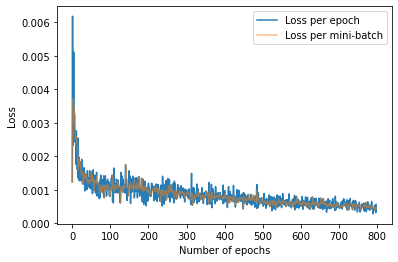

In [9]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        
        loss_per_batch.append(running_loss / (i+1))
    running_loss = 0.0

# Comparing training to test
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
print("Mean Squared Error")
print("Training:", loss_per_batch[-1])
print("Test", criterion(labels.float(), outputs).detach().cpu().numpy())

# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=10, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_iter), step=1) + 1, loss_per_batch, "-",alpha=0.5, label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

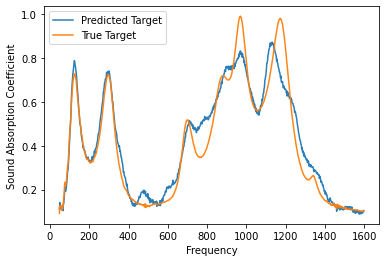

In [23]:
# Comparison between True and Predicted Target Values 
freq_range = range(48,1600,2)
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs = inputs
labels = labels
outputs = model(inputs)
torch.no_grad()
outputs = outputs.detach().numpy()

plt.plot(freq_range, outputs[21], "-", alpha=14,label="Predicted Target")
plt.plot(freq_range, labels[21], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend()
plt.show()

In [11]:
# Optimal Configuration Examination (Below 300Hz)
# Original Samples
dataiter = iter(test_loader)
inputs_real, labels_real = dataiter.next()
inputs_real = inputs_real
labels_real = labels_real
indexes_real = (labels_real[:,:125] > 0.8).nonzero(as_tuple=True)
indexes_real = indexes_real[0]  # Indexes where there's any coefficient value greater than 0.8 in the range of 300Hz

# Tested Samples
dataiter = iter(test_loader)
inputs_test, labels_test = dataiter.next()
inputs_test = inputs_test
labels_test = labels_test
outputs_test = model(inputs_test)
indexes_test = (outputs_test[:,:125] > 0.8).nonzero(as_tuple=True)
indexes_test = indexes_test[0]
outputs_test = outputs_test.detach().numpy()

# Find the actual samples that meet the optimal configuration
indexes_real = list(indexes_real)
optimal_coef_real = []
for i in indexes_real:
    if i not in optimal_coef_real:
        optimal_coef_real.append(i)

# Find the predicted samples that meet the optimal configuration
indexes_test = list(indexes_test)
optimal_coef_test = []
for i in indexes_test:
    if i not in optimal_coef_test:
        optimal_coef_test.append(i)

print("Number of the actual samples that meet the config below 300Hz is", len(optimal_coef_real))
print("Number of the predicted samples that meet the config below 300Hz is", len(optimal_coef_test))

# How many predicted samples match the actual samples
Match_samples = [element for element in optimal_coef_real if element in optimal_coef_test]
print("The prediction accuracy of the algorithm is", len(Match_samples)/len(optimal_coef_real))

# How many incorrect samples the algorithm predicted
Unmatch_samples = [element for element in optimal_coef_test if element not in optimal_coef_real]
print("The number of the incorrectly predicted samples is", len(Unmatch_samples))

Number of the actual samples that meet the config below 300Hz is 6
Number of the predicted samples that meet the config below 300Hz is 5
The prediction accuracy of the algorithm is 0.8333333333333334
The number of the incorrectly predicted samples is 0


In [12]:
optimal_coef_real

[tensor(7), tensor(9), tensor(10), tensor(22), tensor(25), tensor(26)]

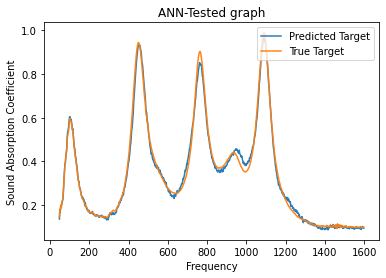

In [36]:
plt.plot(freq_range, outputs_test[15], "-", alpha=14, label="Predicted Target")
plt.plot(freq_range, labels_real[15], "-", alpha=14, label="True Target")
plt.xlabel("Frequency")
plt.ylabel("Sound Absorption Coefficient")
plt.legend(loc=1)
plt.title("ANN-Tested graph")
plt.show()

In [14]:
Unmatch_samples

[]

In [38]:
import seaborn as sns
import tensorflow as tf
labels.tolist()
labels = labels.numpy()

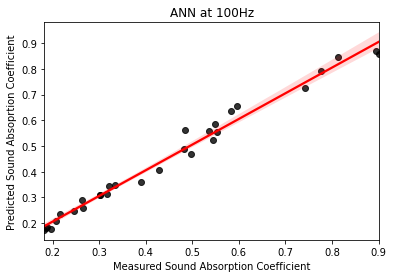

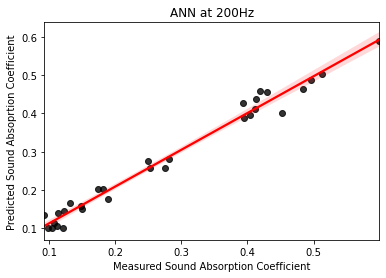

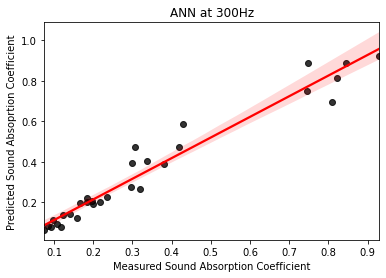

In [40]:
sns.regplot(x=labels[:,50], y= outputs[:,50], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN at 100Hz")
plt.show()

sns.regplot(x=labels[:,100], y= outputs[:,100], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN at 200Hz")
plt.show()

sns.regplot(x=labels[:,150], y= outputs[:,150], scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.xlabel("Measured Sound Absorption Coefficient")
plt.ylabel("Predicted Sound Absoprtion Coefficient")
plt.title("ANN at 300Hz")
plt.show()